Prepare a jupyter notebook (recommended - Google Colab) to build, train and evaluate a Machine/ Deep Learning model on the given dataset. 

# Part A

Dataset - http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html 
The motive of the assignment is to identify whether a person is wearing Eyeglasses, wearing a hat and has a mustache or not. CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including
-10,177 number of identities,
-202,599 number of face images, and
-5 landmark locations, 40 binary attributes annotations per image.

# 1. Import Libraries/Dataset 

# 1. (a) Download the dataset

In [1]:
# ------------------------------------------------------------------------------
# -- Downloading CelebA
# ------------------------------------------------------------------------------

!pip install kaggle

import os 
os.environ['KAGGLE_USERNAME'] = "vishalisrinivasan"
os.environ['KAGGLE_KEY'] = "4dc4c6e17176faa08f03b8aae80a89ff"

!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.32G/1.33G [00:10<00:00, 138MB/s]
100% 1.33G/1.33G [00:10<00:00, 139MB/s]


In [2]:
# ------------------------------------------------------------------------------
# -- unzipping and storing to 'celeba-folder'
# ------------------------------------------------------------------------------

import zipfile

def extract(path, folder):
  zip_ref = zipfile.ZipFile(path, 'r')
  zip_ref.extractall(folder)
  zip_ref.close()

base_folder = 'celeba-dataset'
extract(base_folder + ".zip", base_folder)

for file in os.listdir(base_folder):
  name, ext = os.path.splitext(file)
  if ext == ".zip":
    extract(os.path.join(base_folder, file), base_folder)

In [149]:
# !pip3 install opencv-python
# !pip3 install --upgrade numpy
# !pip3 install --upgrade pandas
# !pip3 install keras
# !pip3 install tensorflow
# !pip3 install sklearn --upgrade
# !pip3 install torchvision
# !pip install imutils
# !pip install --upgrade scikit-learn
# !pip install seaborn --upgrade

# 1. (b) Import the required libraries

In [32]:
import os
import time
import cv2 
import keras
import random
import torch
import random
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob
from tqdm import tqdm
from pprint import pprint
from imutils import paths
from pandas import read_csv

from sklearn import svm
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge

from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Dropout, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import torch.nn as nn
from torch import optim
from torchvision import models
import torch.nn.functional as F
from torchvision import transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Activation, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
%matplotlib inline
plt.style.use('ggplot')

# 2. Data Visualization and Exploration
---
* Wrapping the dataset into the CelebA class
* Getting some info about the dataset (num samples, available attributes, ...)
* Showing some example samples
* Analyzing the features frequencies

In [6]:
# ------------------------------------------------------------------------------
#   CelebA Class
# ------------------------------------------------------------------------------
class CelebA():
  '''Wraps the celebA dataset, allowing an easy way to:
       - Select the features of interest,
       - Split the dataset into 'training', 'test' or 'validation' partition.
  '''
  def __init__(self, main_folder='celeba-dataset/', selected_features=None, drop_features=[]):
    self.main_folder = main_folder
    self.images_folder   = os.path.join(main_folder, 'img_align_celeba/img_align_celeba/')
    self.attributes_path = os.path.join(main_folder, 'list_attr_celeba.csv')
    self.partition_path  = os.path.join(main_folder, 'list_eval_partition.csv')
    self.selected_features = selected_features
    self.features_name = []
    self.__prepare(drop_features)

  def __prepare(self, drop_features):
    '''do some preprocessing before using the data: e.g. feature selection'''
    # attributes:
    if self.selected_features is None:
      self.attributes = pd.read_csv(self.attributes_path)
      self.num_features = 40
    else:
      self.num_features = len(self.selected_features)
      self.selected_features = self.selected_features.copy()
      self.selected_features.append('image_id')
      self.attributes = pd.read_csv(self.attributes_path)[self.selected_features]

    # remove unwanted features:
    for feature in drop_features:
      if feature in self.attributes:
        self.attributes = self.attributes.drop(feature, axis=1)
        self.num_features -= 1
      
    self.attributes.set_index('image_id', inplace=True)
    self.attributes.replace(to_replace=-1, value=0, inplace=True)
    self.attributes['image_id'] = list(self.attributes.index)
  
    self.features_name = list(self.attributes.columns)[:-1]
  
    # load ideal partitioning:
    self.partition = pd.read_csv(self.partition_path)
    self.partition.set_index('image_id', inplace=True)
  
  def split(self, name='training', drop_zero=False):
    '''Returns the ['training', 'validation', 'test'] split of the dataset'''
    # select partition split:
    if name == 'training':
      to_drop = self.partition.where(lambda x: x != 0).dropna()
    elif name == 'validation':
      to_drop = self.partition.where(lambda x: x != 1).dropna()
    elif name == 'test':  # test
      to_drop = self.partition.where(lambda x: x != 2).dropna()
    else:
      raise ValueError('CelebA.split() => `name` must be one of [training, validation, test]')

    partition = self.partition.drop(index=to_drop.index)
      
    # join attributes with selected partition:
    joint = partition.join(self.attributes, how='inner').drop('partition', axis=1)

    if drop_zero == True:
      # select rows with all zeros values
      return joint.loc[(joint[self.features_name] == 1).any(axis=1)]
    elif 0 <= drop_zero <= 1:
      zero = joint.loc[(joint[self.features_name] == 0).all(axis=1)]
      zero = zero.sample(frac=drop_zero)
      return joint.drop(index=zero.index)

    return joint

By printing the length of the image folder, the number of images are within the dataset turns out to be 202,599 images.

In [8]:
# Loading the CelebA dataset.
imagePaths = sorted(list(paths.list_images('celeba-dataset/img_align_celeba')))

f"There are {len(imagePaths)} images in the CelebA dataset."

'There are 202599 images in the CelebA dataset.'

The "list_attr_celeba.csv" contains all labels that are annotated for the dataset. The labels seem to be binary with label "1" indicating the presence of a certain attribute and label "-1" the lack of that attribute. For convenience, label "-1" is changed to 0. For example, when the male attribute has label "0", it means that the image is of a female. Furthermore, the shape of "df_attr" shows that there are 40 different labels for each image in the CelebA dataset.

In [10]:
# Reading the "list_attr_celeba" csv file.
df_attr = pd.read_csv('celeba-dataset/list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)

#The attributes are coded by 1 and -1. 
df_attr.replace(to_replace=-1, value=0, inplace=True) 

no_labels=(df_attr.shape)[1]
f"There are {no_labels} labels for each image."

'There are 40 labels for each image.'

# Listing available features with correspondind label (numeric identifier):

Looping over the colomns to extract the names of these fourty different labels.

In [11]:
print("CelebA Facial Attributes:")

for index, attribute_name in enumerate(CelebA().attributes.columns[:-1]):
  print(f"{index}: {attribute_name}")

CelebA Facial Attributes:
0: 5_o_Clock_Shadow
1: Arched_Eyebrows
2: Attractive
3: Bags_Under_Eyes
4: Bald
5: Bangs
6: Big_Lips
7: Big_Nose
8: Black_Hair
9: Blond_Hair
10: Blurry
11: Brown_Hair
12: Bushy_Eyebrows
13: Chubby
14: Double_Chin
15: Eyeglasses
16: Goatee
17: Gray_Hair
18: Heavy_Makeup
19: High_Cheekbones
20: Male
21: Mouth_Slightly_Open
22: Mustache
23: Narrow_Eyes
24: No_Beard
25: Oval_Face
26: Pale_Skin
27: Pointy_Nose
28: Receding_Hairline
29: Rosy_Cheeks
30: Sideburns
31: Smiling
32: Straight_Hair
33: Wavy_Hair
34: Wearing_Earrings
35: Wearing_Hat
36: Wearing_Lipstick
37: Wearing_Necklace
38: Wearing_Necktie
39: Young


We tabulated these attributes for a subset of images showing their respective labels.


In [ ]:
samples = df_attr.sample(frac=1, random_state=42).reset_index(drop=True)
samples.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0


In [ ]:
celeba = CelebA()

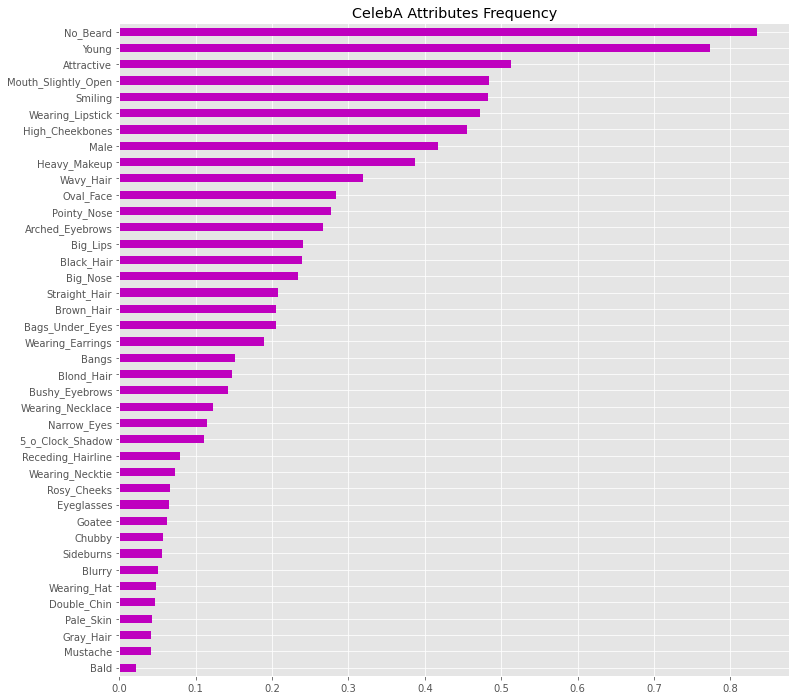

In [ ]:
# ------------------------------------------------------------------------------
# -- Computing sorted features frequency on all the 202k entries
# ------------------------------------------------------------------------------
frequencies = celeba.attributes.mean(axis=0).sort_values()

_ = frequencies.plot(title='CelebA Attributes Frequency', 
                     kind='barh', 
                     figsize=(12, 12),
                     color='m')

Here, we can clearly observe a data imbalance problem. 

The frequency of the facial attributes vary a lot, rather than being roughly equal to each other. There are rare attributes (Bald, Mustache, Double_Chin, etc) with a frequency below 10%, and a couple of very common attributes (No_Beard, Young) with a frequency above 70%.

The dataset is biased with respect to young and beardless people.

When the data is imbalanced, the model can easily overfit the datapoints. 

In this case, it can learn to always output a 1 for every common attributes, and always output a 0 for the rare attributes: the model finds out that this strategy (predicting 0s and 1s) is good (which is not true, because it doesn’t learn patterns). Following this fashion, the model’s output predictions will look like [1, 0, ..., 0, 1] vectors, all the same for every image.

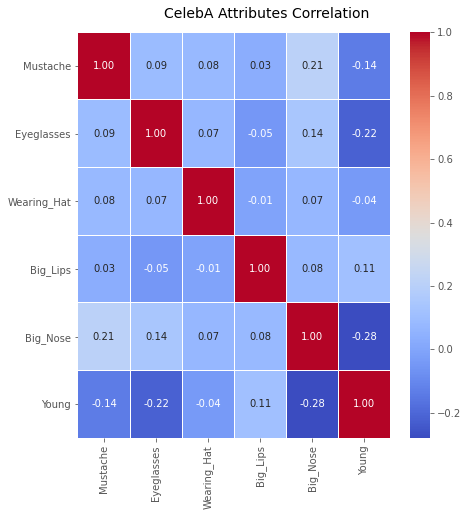

In [ ]:
# set the size of the confusion matrix.
f, ax = plt.subplots(figsize=(7, 7))

# pick a sample of the attributes
subset_attr = ['Mustache','Eyeglasses','Wearing_Hat','Big_Lips','Big_Nose','Young']
corr = df_attr[subset_attr].corr()
# plot the matrix using seaborn
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('CelebA Attributes Correlation', fontsize=14)

In [12]:
# selecting 3 out of 40 features

celeba = CelebA(drop_features=['5_o_Clock_Shadow','Arched_Eyebrows', 'Attractive','Bags_Under_Eyes','Bald','Bangs','Big_Lips','Big_Nose','Black_Hair','Blond_Hair','Blurry','Brown_Hair','Bushy_Eyebrows','Chubby','Double_Chin','Goatee','Gray_Hair','Heavy_Makeup','High_Cheekbones','Male','Mouth_Slightly_Open','Narrow_Eyes','No_Beard','Oval_Face','Pale_Skin','Pointy_Nose','Receding_Hairline','Rosy_Cheeks','Sideburns','Smiling','Straight_Hair','Wavy_Hair','Wearing_Earrings','Wearing_Lipstick','Wearing_Necklace','Wearing_Necktie','Young'])

# couting number of samples per partition:
print(f"total entries: {celeba.attributes.shape[0]}")
print(f"  - training: {celeba.split('training').shape[0]}")
print(f"  - validation: {celeba.split('validation').shape[0]}")
print(f"  - test: {celeba.split('test').shape[0]}")

total entries: 202599
  - training: 162770
  - validation: 19867
  - test: 19962


# 2. (a) Print at least 5 rows for sanity check to identify all the features present in the dataset and if the target matches with them.

In [13]:
# shows five random samples
celeba.attributes.sample(5)

,Eyeglasses,Mustache,Wearing_Hat,image_id
image_id,,,,
199352.jpg,0,0,0,199352.jpg
192029.jpg,1,1,0,192029.jpg
046090.jpg,0,0,0,046090.jpg
144439.jpg,0,0,0,144439.jpg
025064.jpg,0,0,0,025064.jpg


Every image is associated to a vector of binary labels, where each attribute can be 0 or 1

# 2. (b) Print the description of the dataset.

In [ ]:
celeba.attributes.describe()

,Eyeglasses,Mustache,Wearing_Hat
count,202599.000000,202599.000000,202599.000000
mean,0.065119,0.041545,0.048460
std,0.246736,0.199548,0.214737
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


# 2. (b) Print the shape of the dataset.

In [ ]:
celeba.attributes.shape

(202599, 4)

# 2. (c) Provide appropriate visualization to get an insight about the dataset.

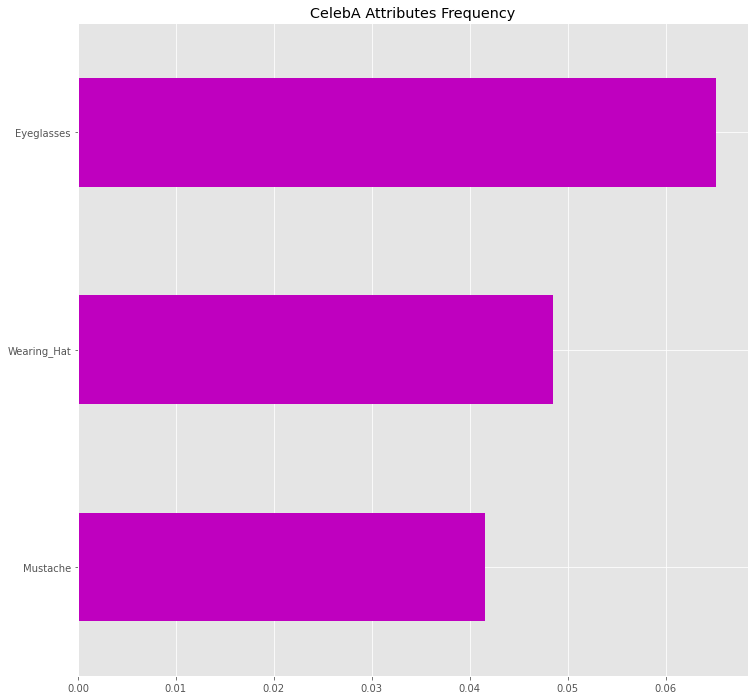

In [ ]:
# ------------------------------------------------------------------------------
# -- Computing sorted features frequency on all the 202k entries
# ------------------------------------------------------------------------------

frequencies = celeba.attributes.mean(axis=0).sort_values()

_ = frequencies.plot(title='CelebA Attributes Frequency', 
                     kind='barh', 
                     figsize=(12, 12),
                     color='m')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ffe0a3f50>,
      dtype=object)

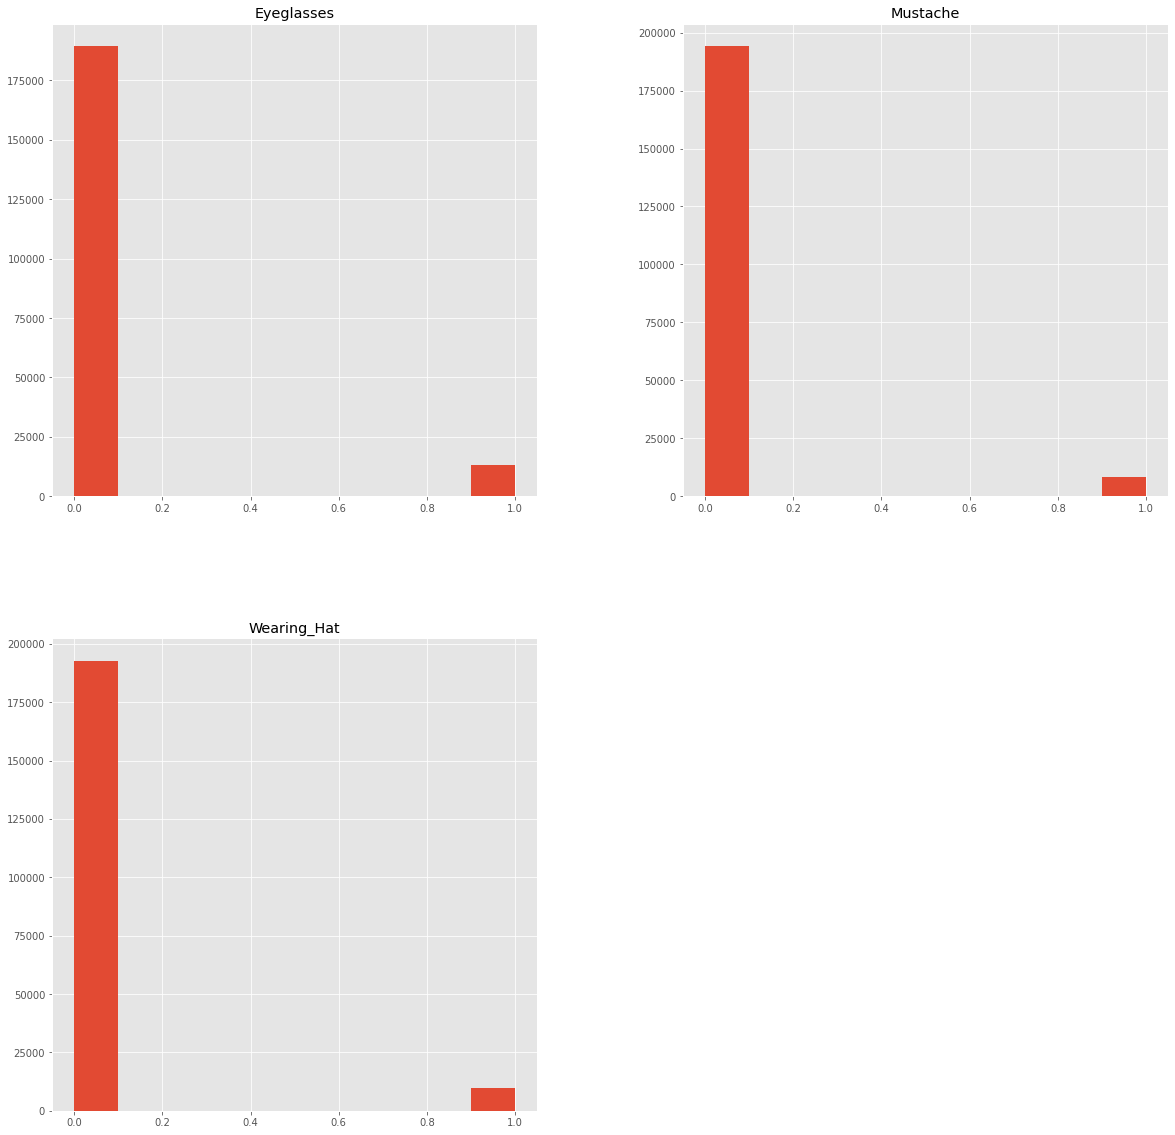

In [ ]:
import matplotlib.pyplot as plt
celeba.attributes[celeba.attributes.dtypes[(celeba.attributes.dtypes=="float64")|(celeba.attributes.dtypes=="int64")]
                        .index.values].hist(figsize=[20,20])

# 2. (d) Try exploring the data and see what insights can be drawn from the dataset.

In [ ]:
celeba.attributes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202599 entries, 000001.jpg to 202599.jpg
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Eyeglasses   202599 non-null  int64 
 1   Mustache     202599 non-null  int64 
 2   Wearing_Hat  202599 non-null  int64 
 3   image_id     202599 non-null  object
dtypes: int64(3), object(1)
memory usage: 17.7+ MB



# Shows a random sample image with its attributes:


path: 'celeba-dataset/img_align_celeba/img_align_celeba/087426.jpg'
attributes: [0 0 0]


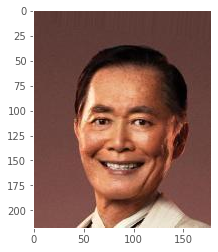

,Eyeglasses,Mustache,Wearing_Hat
image_id,,,
087426.jpg,0,0,0


In [ ]:
# ------------------------------------------------------------------------------
# -- Shows a random sample image with its attributes:
# ------------------------------------------------------------------------------

# pick a sample
random_sample = celeba.attributes.sample(1)
pic_path = os.path.join(celeba.images_folder, random_sample.index[0])

print(f"path: '{pic_path}'")
print(f"attributes: {random_sample.to_numpy()[0, :-1]}")

# load and convert the image
pic = cv2.imread(pic_path)
pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)

# plot with attributes
plt.imshow(pic)
plt.grid(False)
plt.show()

random_sample.drop('image_id', axis=1)

# 3. Data Pre-processing and cleaning

# 3. (a) Do the appropriate preprocessing of the data like Use image augmentation if needed.


The practice of Data Augmentation is an effective way to increase the size of the training set.
Augmenting the training examples allow the network to “see” more diversified, but still representative, datapoints 
during training.
The following code defines a set of augmentations for the training-set: 
rotation, shift, shear, flip, and zoom.

Note that both the validation-set and test-set must not be augmented.

Then we define a couple of data generators: one for training data, and the other for validation data.

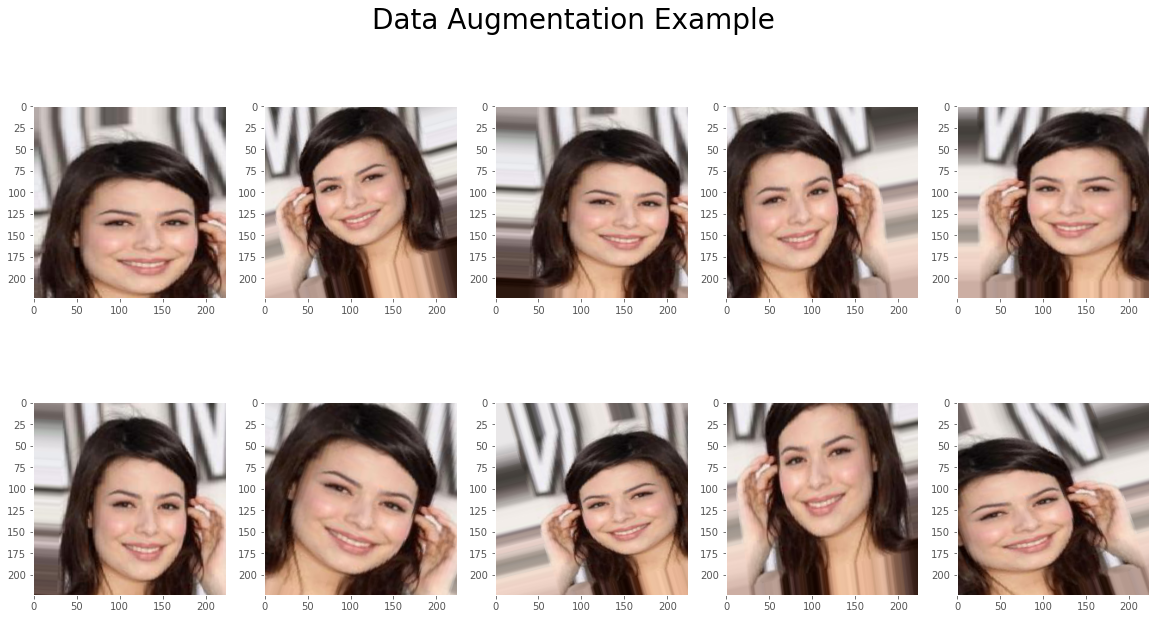

In [14]:
img_size = 224 #@param ["192", "224"] {type:"raw", allow-input: true}

IMG_W = img_size 
IMG_H = img_size
IMG_SHAPE = (IMG_H, IMG_W, 3)
TARGET_SIZE = (IMG_H, IMG_W)

#@title Training Parameters
batch_size = 80 #@param ["64", "80", "96", "128"] {type:"raw", allow-input: true}
num_epochs = 12 #@param ["8", "16", "32"] {type:"raw", allow-input: true}

# ------------------------------------------------------------------------------
#  Preparing Data Generators for training and validation set
# ------------------------------------------------------------------------------

# data augmentation only for the training istances:
train_datagen = ImageDataGenerator(rotation_range=20, 
                                   rescale=1./255, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)


# get training and validation set:
train_split = celeba.split('training'  , drop_zero=False)
valid_split = celeba.split('validation', drop_zero=False)

# ------------------------------------------------------------------------------
#   Example of the augmented samples
# ------------------------------------------------------------------------------

def load_reshape_img(path, shape=IMG_SHAPE):
  img = load_img(path, target_size=shape)
  x = img_to_array(img) / 255.0
  x = x.reshape((1, ) + x.shape)
  return x


# select and load a picture:
sample_path = os.path.join(celeba.images_folder, train_split.sample(1).index[0])
sample = load_reshape_img(sample_path)

# plot ten augmented images
plt.figure(figsize=(20, 10))
plt.suptitle('Data Augmentation Example', fontsize=28)

for i, image in enumerate(train_datagen.flow(sample, batch_size=1)):
  if i == 10:
    break
    
  plt.subplot(2, 5, i + 1)
  plt.grid(False)
  plt.imshow(image.reshape(IMG_SHAPE) * 255.)

_ = plt.show()

# 3. (b) Apply the feature transformation techniques like Standardization, Normalization, etc.
# You are free to apply the appropriate transformations depending upon the structure and the complexity of your dataset.

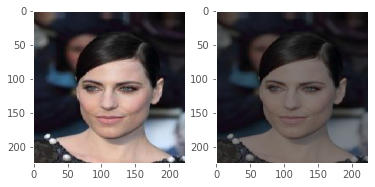

In [15]:
transformer = FunctionTransformer(func=np.log1p)

def apply_transformation(path, shape=IMG_SHAPE):
    img = load_img(path, target_size=shape)
    x = img_to_array(img) / 255.0
    plt.grid(False)
    plt.subplot(1, 2, 1)
    plt.grid(False)
    plt.imshow(img)
    x = transformer.transform(x)
    plt.subplot(1, 2, 2)
    plt.grid(False)
    plt.imshow(transformer.transform(x))


# select and load a picture:
sample_path = os.path.join(celeba.images_folder, train_split.sample(1).index[0])
apply_transformation(sample_path)
_ = plt.show()

# 3. (c) Do the correlational analysis on the dataset. Provide a visualization for the same.

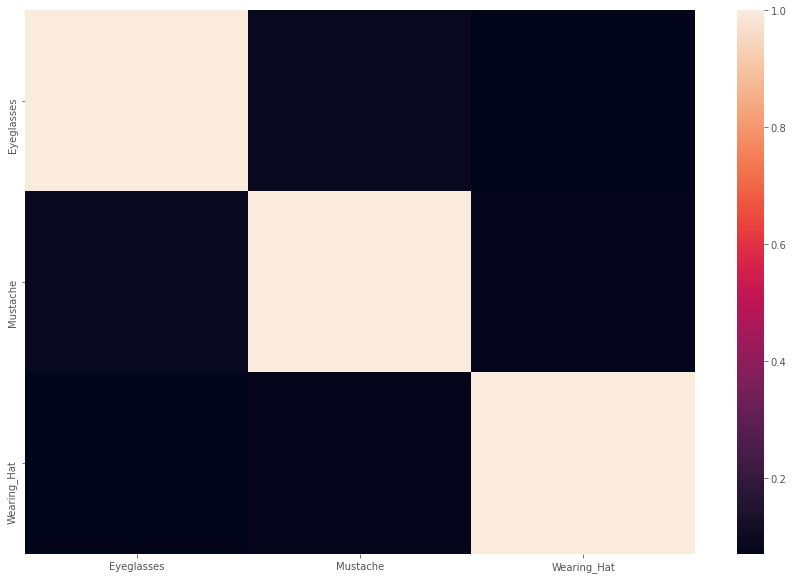

In [ ]:
# Plot heatmap of feature correlation 
plt.figure(figsize = (15,10))
sns.heatmap(celeba.attributes.corr())

In [ ]:
print(celeba.attributes[["Mustache","Eyeglasses","Wearing_Hat"]].corr())
plt.figure(figsize = (6,6))

             Mustache  Eyeglasses  Wearing_Hat
Mustache     1.000000    0.092721     0.079147
Eyeglasses   0.092721    1.000000     0.070956
Wearing_Hat  0.079147    0.070956     1.000000


<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

# 4. Data Preparation
 (a) Do the final feature selection and extract them into Column X and the class label into Column into Y.
 
 (b) Split the dataset into training and test sets.

# Part B (12 marks)

# 1. Model Building
(a) Perform Model Development using at least three models, separately. 
You are free to apply any Machine/Deep Learning Models on the dataset. 

(b)	 Train the model and print the training accuracy and loss values.
# 2.	Performance Evaluation
(a)	Print the confusion matrix. Provide appropriate analysis for the same.

(b)	Do the prediction for the test data and display the results for the inference. 


# Model 1
# Model Architecture
---
* MobileNetV2: as the base architecture pre-trained on 'imagenet'
* Summary: layers, num of parameters.

In [ ]:
# Model Input
img_size = 224 #@param ["192", "224"] {type:"raw", allow-input: true}

IMG_W = img_size 
IMG_H = img_size
IMG_SHAPE = (IMG_H, IMG_W, 3)
TARGET_SIZE = (IMG_H, IMG_W)

In [ ]:
# The architecture: 

def mobilenet_model(num_features):
  base = MobileNetV2(input_shape=IMG_SHAPE,
                     weights=None,
                     include_top=False,
                     pooling='avg')
  
  # model top
  x = base.output
  x = Dense(1536, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x)
  top = Dense(num_features, activation='sigmoid')(x)
  time.sleep(0.1)
  return Model(inputs=base.input, outputs=top)

In [ ]:
model = mobilenet_model(num_features=celeba.num_features)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

# Training
---
* Data generators (for training and validation)
* Image Augmentation: zoom, rotation, shear, shift.
* Optimizer
* Checkpointing
* Fitting

In [ ]:
# Training Parameters
batch_size = 80 #@param ["64", "80", "96", "128"] {type:"raw", allow-input: true}
num_epochs = 12 #@param ["8", "16", "32"] {type:"raw", allow-input: true}

In [ ]:
# ------------------------------------------------------------------------------
# -- Preparing Data Generators for training and validation set
# ------------------------------------------------------------------------------

# data augmentation only for the training istances:
train_datagen = ImageDataGenerator(rotation_range=20, 
                                   rescale=1./255, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)


# get training and validation set:
train_split = celeba.split('training'  , drop_zero=False)
valid_split = celeba.split('validation', drop_zero=False)


# data generators:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_split,
    directory=celeba.images_folder,
    x_col='image_id',
    y_col=celeba.features_name,
    target_size=TARGET_SIZE,
    batch_size=batch_size,
    class_mode='raw'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_split,
    directory=celeba.images_folder,
    x_col='image_id',
    y_col=celeba.features_name,
    target_size=TARGET_SIZE,
    batch_size=batch_size,
    class_mode='raw'
)

Found 162770 validated image filenames.
Found 19867 validated image filenames.


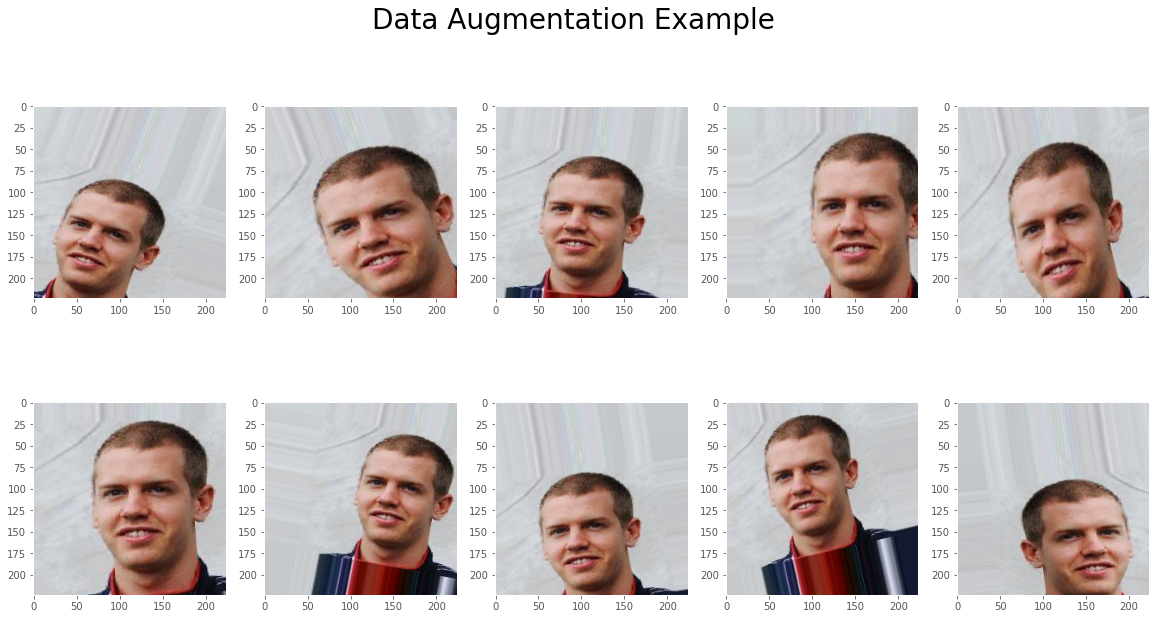

In [ ]:
# ------------------------------------------------------------------------------
# -- Example of the augmented samples:
# ------------------------------------------------------------------------------

def load_reshape_img(path, shape=IMG_SHAPE):
  img = load_img(path, target_size=shape)
  x = img_to_array(img) / 255.0
  x = x.reshape((1, ) + x.shape)
  return x


# select and load a picture:
sample_path = os.path.join(celeba.images_folder, train_split.sample(1).index[0])
sample = load_reshape_img(sample_path)

# plot ten augmented images
plt.figure(figsize=(20, 10))
plt.suptitle('Data Augmentation Example', fontsize=28)

for i, image in enumerate(train_datagen.flow(sample, batch_size=1)):
  if i == 10:
    break
    
  plt.subplot(2, 5, i + 1)
  plt.grid(False)
  plt.imshow(image.reshape(IMG_SHAPE) * 255.)

_ = plt.show()

In [ ]:
# ------------------------------------------------------------------------------
# -- Compile model
# ------------------------------------------------------------------------------

model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adadelta',  # adadelta, adam, nadam
              metrics=[keras.metrics.BinaryAccuracy()])

In [ ]:
# COLAB-ONLY: load/save content from drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

save_path = "/content/gdrive/My Drive/modelli/keras" 

def save_in_drive(fname, content):
  with open(f'{save_path}/{fname}', 'w') as f:
    f.write(content)
    
def load_from_drive(fname):
  with open(f'{save_path}/{fname}', 'r') as f:
    return f.read()

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# ------------------------------------------------------------------------------
# -- Checkpointing: at each epoch, the best model so far is saved
# ------------------------------------------------------------------------------

model_path = f"weights-FC40-MobileNetV2" + "{val_binary_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(
    model_path,
    monitor='val_binary_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
# ------------------------------------------------------------------------------
# -- Fitting
# ----------------------------------------------------------------------------
history = model.fit_generator(
    train_generator,
    epochs=num_epochs,
    steps_per_epoch=len(train_generator),
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    max_queue_size=1,
    shuffle=True,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/12
2035/2035 [==============================] - 1080s 531ms/step - loss: 0.7007 - binary_accuracy: 0.9383 - val_loss: 0.6931 - val_binary_accuracy: 0.9442

Epoch 00001: val_binary_accuracy improved from -inf to 0.94420, saving model to weights-FC40-MobileNetV20.94.hdf5
Epoch 2/12
2035/2035 [==============================] - 1061s 521ms/step - loss: 0.6932 - binary_accuracy: 0.9484 - val_loss: 0.6932 - val_binary_accuracy: 0.9442

Epoch 00002: val_binary_accuracy improved from 0.94420 to 0.94420, saving model to weights-FC40-MobileNetV20.94.hdf5
Epoch 3/12
2035/2035 [==============================] - 1061s 521ms/step - loss: 0.6932 - binary_accuracy: 0.9484 - val_loss: 0.6954 - val_binary_accuracy: 0.9442

Epoch 00003: val_binary_accuracy did not improve from 0.94420
Epoch 4/12
2035/2035 [==============================] - 1061s 521ms/step - loss: 0.6932 - binary_accuracy: 0.9484 - val_loss: 0.6931 - val_binary_accuracy: 0.9442

Epoch 00004: val_binary_accuracy did not improve fr

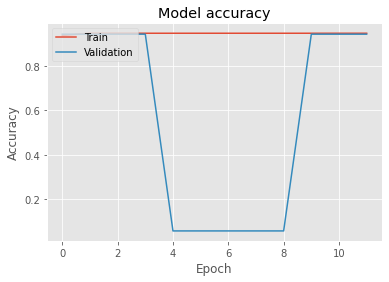

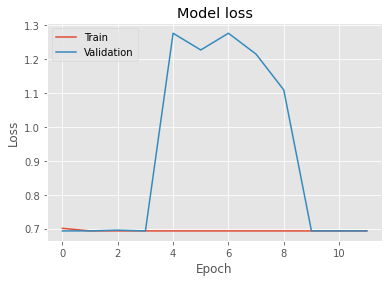

In [ ]:
def plot_model_history(history):
  '''plots useful graphs about the model training: loss, accuracy, ecc.'''
  plt.plot(history.history['binary_accuracy'])
  plt.plot(history.history['val_binary_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  
# plot the training and validation loss for every epoch:
plot_model_history(history)

# 4. Testing
---
* Test Data Generator
* Evaluate performance on test-set
* Average Hamming Distance, Mis-predictions
* Plot Mis-predictions frequency, and accuracy per feature

In [ ]:
# optionally load a pre-trained model:

model = keras.models.load_model(f"{save_path}/UL19/weights-FC37-MobileNetV2-0.92.hdf5")

In [36]:
# ------------------------------------------------------------------------------
# -- Data Generator for Test-Set
# ------------------------------------------------------------------------------

test_datagen = ImageDataGenerator(rescale=1./255)

test_set = celeba.split('test', drop_zero=False)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_set,
    directory=celeba.images_folder,
    x_col='image_id',
    y_col=celeba.features_name,
    target_size=TARGET_SIZE,
    batch_size=batch_size,
    class_mode='raw'
)

Found 19962 validated image filenames.


In [ ]:
# ------------------------------------------------------------------------------
# -- Evaluate Accuracy
# ------------------------------------------------------------------------------

score = model.evaluate_generator(
    test_generator,
    steps=len(test_generator),
    max_queue_size=1,
    verbose=1
)

print("Test score:", score[0])
print("Test accuracy:", score[1]) 

250/250 [==============================] - 27s 108ms/step
Test score: 0.6931496858596802
Test accuracy: 0.9515746831893921


In [ ]:
def hamming_distance(x, y):
  '''Hamming distance: use to get the number of mis-predicted features'''
  assert(len(x) == len(y))
  
  count = 0
  for i in range(len(x)):
    if x[i] != y[i]:
      count += 1
  
  return count


def count_mistakes(preds, labels):
  '''For every feature counts the number mis-predictions'''
  mistakes = np.zeros(len(preds[0]))
  
  for i, pred in enumerate(preds):
    label = labels[i]
    
    for j in range(len(pred)):
      if pred[j] != label[j]:
        mistakes[j] += 1
    
  return mistakes

In [ ]:
# ------------------------------------------------------------------------------
# -- Avg. Hamming Distance, Mis-predictedion frequency
# ------------------------------------------------------------------------------

mistakes = np.zeros(celeba.num_features)
count = 0
avg_d = 0
show_prob = 0.01
times_one = np.zeros(celeba.num_features)

# generate samples (x), and labels (y) a batch at a time:
for i in range(len(test_generator)):
  x, y  = next(test_generator)
  preds = model.predict_on_batch(x)
  preds = np.round(preds).astype('int')  # make the prediction a binary vector
  count += len(x)
  
  mistakes += count_mistakes(preds, y)
  
  for i, p in enumerate(preds):
    d = hamming_distance(p, y[i])
    avg_d += d
    times_one += p
    
    if random.random() <= show_prob:
      # prints: prediction, true labels, and their hamming distance
      print(f"pred: {p}") 
      print(f"true: {y[i]}")
      print(f"=> d = {d}")
    
# get average hamming distance:    
avg_d /= count
print("avg. hamming: " + str(avg_d))

mistakes2 = []
for i, times in enumerate(times_one):
  val = mistakes[i] / times
  mistakes2.append(round(val, 2))

mistakes = np.round(mistakes / count, 2)

pred: [0 0 0]
true: [0 0 0]
=> d = 0
pred: [0 0 0]
true: [0 0 0]
=> d = 0
pred: [0 0 0]
true: [1 0 0]
=> d = 1
pred: [0 0 0]
true: [0 0 0]
=> d = 0
pred: [0 0 0]
true: [0 0 0]
=> d = 0
pred: [0 0 0]
true: [0 0 0]
=> d = 0
pred: [0 0 0]
true: [0 0 0]
=> d = 0
pred: [0 0 0]
true: [0 0 0]
=> d = 0
pred: [0 0 0]
true: [0 0 0]
=> d = 0
pred: [0 0 0]
true: [0 0 0]
=> d = 0
pred: [0 0 0]
true: [0 0 0]
=> d = 0
pred: [0 0 0]
true: [0 1 0]
=> d = 1
pred: [0 0 0]
true: [0 1 0]
=> d = 1
pred: [0 0 0]
true: [0 0 0]
=> d = 0
pred: [0 0 0]
true: [0 0 0]
=> d = 0
pred: [0 0 0]
true: [0 0 0]
=> d = 0
pred: [0 0 0]
true: [0 0 0]
=> d = 0
pred: [0 0 0]
true: [0 0 0]
=> d = 0
pred: [0 0 0]
true: [0 0 0]
=> d = 0
pred: [0 0 0]
true: [0 0 0]
=> d = 0
pred: [0 0 0]
true: [0 0 0]
=> d = 0
pred: [0 0 0]
true: [0 0 0]
=> d = 0
pred: [0 0 0]
true: [0 0 0]
=> d = 0
pred: [0 0 0]
true: [0 0 0]
=> d = 0
pred: [0 0 0]
true: [0 1 0]
=> d = 1
pred: [0 0 0]
true: [0 1 1]
=> d = 2
pred: [0 0 0]
true: [0 0 0]
=> d = 0
p

/home/rk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


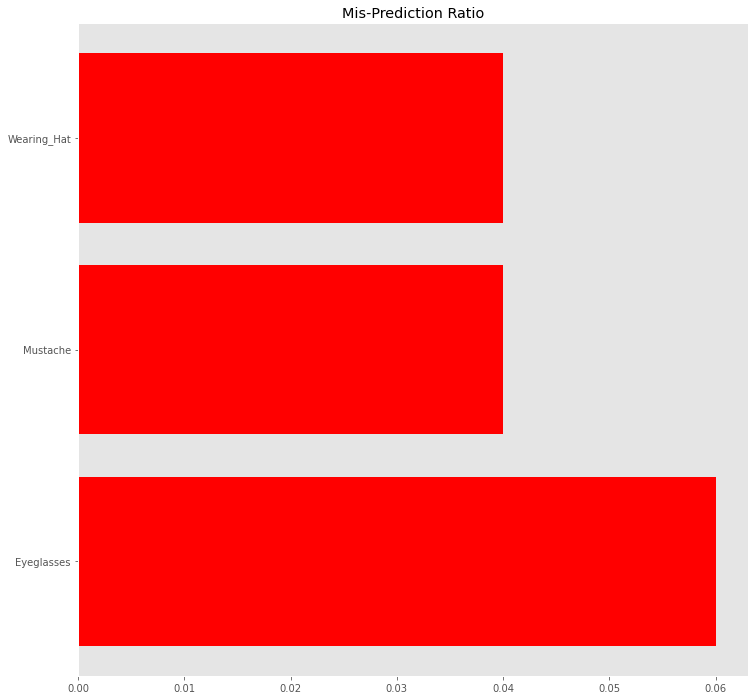

In [ ]:
# plot mis-predicted feature ratio

plt.figure(figsize=(12, 12))

plt.barh(celeba.features_name, mistakes, color='red')
plt.title("Mis-Prediction Ratio")
plt.grid(False)

_ = plt.show()

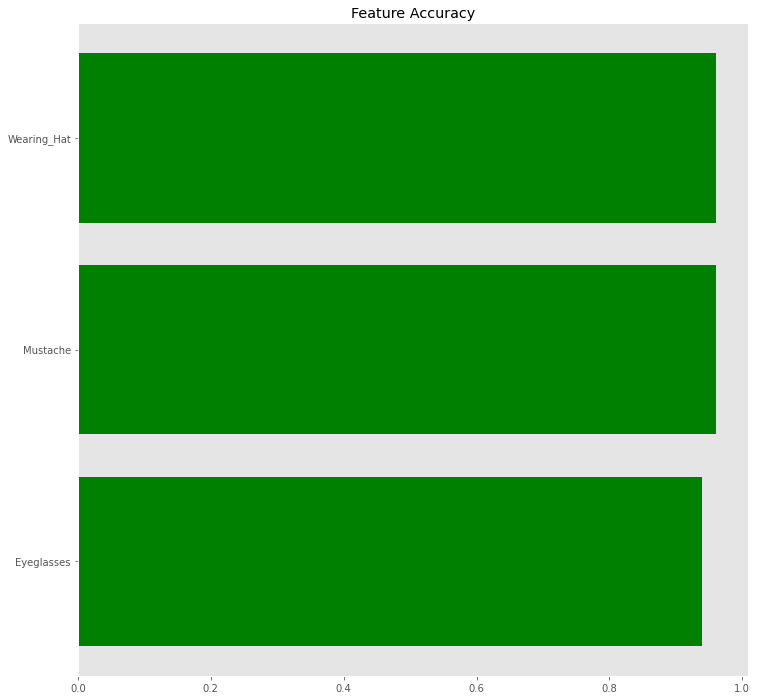

In [ ]:
# plot feature accuracy
plt.figure(figsize=(12, 12))

plt.barh(celeba.features_name, 1 - mistakes, color='green')
plt.title("Feature Accuracy")
plt.grid(False)

_ = plt.show()

# Model 2
# Model  Architecture
* ResNet50: as the base architecture pre-trained on 'imagenet'
* Summary: layers, num of parameters.

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Activation, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import gdown

import os

In [5]:
IMGS_ATTR_PATH = '/content/celeba-dataset/list_attr_celeba.csv'
IMGS_PATH = '/content/celeba-dataset/img_align_celeba/img_align_celeba'

FACE_WEIGHT_VGG16 = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_vgg16.h5'

MODEL_20_EPOCHS = 'https://drive.google.com/uc?id=18N6-jvBPCODlgyyo0YiPiPTUxeyGBk0q'
MODEL_NAME = 'model_20_epoch.h5'

In [6]:
def get_attr_names(dataframe):
    '''
    This function returns attr names using in dataset.
    
    Params:
        dataframe (pd.Dataframe)
        
    Return:
        attr_names (list): A list object containing the name of attribute name of celeb faces.
    '''
    attr_names = []
    attr_names = list(dataframe.columns)
    # removing images_id column
    del attr_names[0]
    
    return attr_names

def attr_to_onehot(array):
    '''
    This function just make attr values in array to onehot by changing -1 to 0.
    '''
    result = np.copy(array)
    result[result == -1] = 0
    return result

def split_dataset(ds, percentage=0.2):
    '''
    This function can split the dataset in two parts with given percentage.
    
    Params: 
        ds (np.array): Numpy array representing dataset.
        percentage (float, optional): Between 0 and 1.
        
    Returns:
        main (np.array): This array contains lenght of 1-percentage of total dataset.
        other (np.array): This array contains length of percentage of total dataset.
    '''
    cut_size = int(percentage * len(ds))
    cut_indices = np.random.randint(0, len(ds), size=(cut_size, ))
    
    other = ds[cut_indices]
    main = np.delete(ds, cut_indices, axis=0)
    
    print('--------------------------------------')
    print("TOTAL:\t{} \nFIRST:\t{} \nSECOND:\t{}".format(len(ds), len(main), len(other)))
    print('--------------------------------------')
    
    return main, other

def plot_attr(attr_names):
    f = plt.figure(figsize=(20, 15))
    for i, attr_name in enumerate(attr_names):
        f.add_subplot(4, 10, i+1)
        col = attr_df[attr_name]
        g = sns.barplot(x=col.value_counts().index, y=col.value_counts(normalize=True))
        g.set(ylim=(0, 1))
        plt.yticks([])
    plt.show()

In [27]:
attr_df = pd.read_csv(IMGS_ATTR_PATH)
attr_df.drop(['5_o_Clock_Shadow','Arched_Eyebrows', 'Attractive','Bags_Under_Eyes','Bald','Bangs','Big_Lips','Big_Nose','Black_Hair','Blond_Hair','Blurry','Brown_Hair','Bushy_Eyebrows','Chubby','Double_Chin','Goatee','Gray_Hair','Heavy_Makeup','High_Cheekbones','Male','Mouth_Slightly_Open','Narrow_Eyes','No_Beard','Oval_Face','Pale_Skin','Pointy_Nose','Receding_Hairline','Rosy_Cheeks','Sideburns','Smiling','Straight_Hair','Wavy_Hair','Wearing_Earrings','Wearing_Lipstick','Wearing_Necklace','Wearing_Necktie','Young'],axis=1, inplace=True)
attr_df.head()

,image_id,Eyeglasses,Mustache,Wearing_Hat
0,000001.jpg,-1,-1,-1
1,000002.jpg,-1,-1,-1
2,000003.jpg,-1,-1,-1
3,000004.jpg,-1,-1,-1
4,000005.jpg,-1,-1,-1


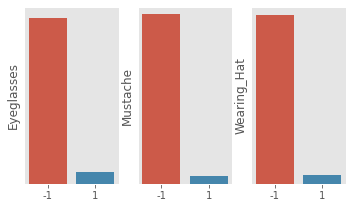

In [28]:
attr_names = get_attr_names(attr_df)
plot_attr(attr_names)

In [29]:
attr2idx = {v:i for i, v in enumerate(attr_names)}

attr2idx

{'Eyeglasses': 0, 'Mustache': 1, 'Wearing_Hat': 2}

In [30]:
attr_np = np.array(attr_df)
attr_np.shape

(202599, 4)

In [31]:
celeb_dataset = attr_to_onehot(attr_np)
celeb_dataset[:5]

array([['000001.jpg', 0, 0, 0],
       ['000002.jpg', 0, 0, 0],
       ['000003.jpg', 0, 0, 0],
       ['000004.jpg', 0, 0, 0],
       ['000005.jpg', 0, 0, 0]], dtype=object)

In [32]:
train_np, test_np = split_dataset(celeb_dataset, 0.1)

--------------------------------------
TOTAL:	202599 
FIRST:	183321 
SECOND:	20259
--------------------------------------


In [33]:
def load_to_tfds(array):
    """
    This function just take np.array and extract imgs_path and attr_list
    seperately and then make seperate tensorflow dataset for both. Return 
    tensorflow dataset by zipping these two generated datasets.

    Args:
        array (np.array): Numpy array representing dataset

    Returns:
        ds (tf.data.Dataset): Tensorflow dataset containing zipped image and 
                              Respective attributes list.
    """ 
    img_path = array[:, 0]
    img_attrs = array[:, 1:]
    
    path_ds = tf.data.Dataset.from_tensor_slices(img_path)
    attrs_ds = tf.data.Dataset.from_tensor_slices(img_attrs.astype(np.int16))
    
    ds = tf.data.Dataset.zip((path_ds, attrs_ds))
    
    return ds

def load_and_process_image(name, attrs, augment=False):
    """
    This function take name(of image) and attrs(of image) and returns
    loaded image with attrs.

    Args:
        name (tf.string): String representing the name of image.
        attrs (tf.int): List representing the attributes of image.

    Returns:
        (image, attrs): Loaded image with attributes list.
    """
    full_path = IMGS_PATH + os.sep + name
    image = tf.io.read_file(full_path)
    image = tf.io.decode_jpeg(contents=image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.divide(image, 255.)
    image = tf.image.resize(image, size=(112, 112))
    if (augment):
        image = tf.image.random_flip_left_right(image)
    return image, attrs

def preprocess_ds(ds, batch_size=128):
    """
    Batch and prefetch batched thats it.

    Args:
        ds (tf.data.Dataset): Tensorflow dataset
        batch_size (int, optional): Number of items to be in single batch. Defaults to 128.

    Returns:
        ds: Tensorflow dataset
    """
    ds = ds.shuffle(256)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [34]:
train_ds = load_to_tfds(train_np)
test_ds = load_to_tfds(test_np)

train_ds = train_ds.map(lambda x, y: load_and_process_image(x, y, True))
test_ds = test_ds.map(load_and_process_image)

train_ds = preprocess_ds(train_ds, batch_size=64)
test_ds = preprocess_ds(test_ds, batch_size=64)

In [43]:
def get_label_string(label):
    '''
    This function return string representation of label list
    
    Params:
        label (list) : A onehot representation of labels
        
    Return:
        joined by \n string from every element of list
    '''
    true_label = np.array(list(attr2idx.keys()))[label==1]
    return ', '.join(true_label)

def plot_images(images, labels, pred_labels=[]):
    '''
    This function plot the images one by one in 1x5 grid with string representation of label as title of
    respective image.
    
    Params:
        images (np.ndarray) : images to plot
        labesl (np.ndarray) : labels to plot as title
        pred_labels (nd.ndarray) : predicted labels to compare with true labels
    '''
    for i, image in enumerate(images):
        _ = plt.figure(figsize=(4, 4))
        print('-----------------------')
        print('True Attributes among [wearing Eyeglasses, wearing_hat, mustache]: ', get_label_string(labels[i]))
        if len(pred_labels) != 0:
            print('Predicted Attributes:', get_label_string(pred_labels[i]))
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        print('-----------------------')

-----------------------
True Attributes: 


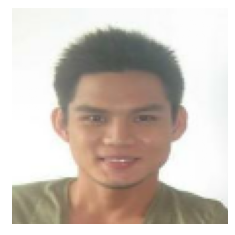

-----------------------
-----------------------
True Attributes: Wearing_Hat


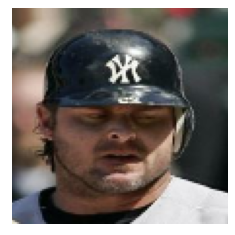

-----------------------
-----------------------
True Attributes: 


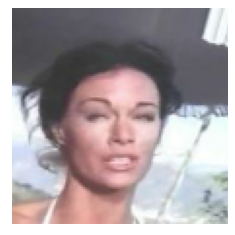

-----------------------
-----------------------
True Attributes: 


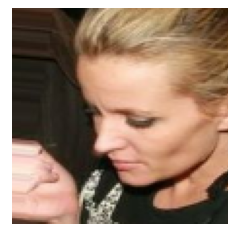

-----------------------
-----------------------
True Attributes: 


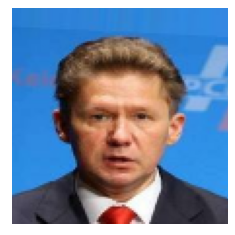

-----------------------


In [36]:
images, labels = next(iter(train_ds))
images, labels = images.numpy()[:5], labels.numpy()[:5]

plot_images(images, labels)

In [37]:
def vgg16_model():
    '''
    This function is used to create the model. In this model i'll be using vgg16 pretrained model on vggface dataset.
    Notice i'm using GlobalAveragePooling instead of Dense layer.
    
    Returns:
        classifier (tf.keras.Model) : Custom model with resnet_50 pretrained.
    '''
    vgg_features = VGG16(include_top=False, input_shape=(112, 112, 3), pooling='avg', weights=None)
    face_weights = tf.keras.utils.get_file('vgg16_notop_weights', FACE_WEIGHT_VGG16)
    vgg_features.load_weights(face_weights)
    for layer in vgg_features.layers:
        layer.trainable = False
    classifier = Sequential([
        vgg_features,
        Dense(len(attr2idx)),
        Activation('sigmoid')
    ])
    return classifier

def resnet50_model():
    '''
    This function is used to create the model. In this model i'll be using resnet50 pretrained model on imagenet dataset.
    Notice i'm using GlobalAveragePooling instead of Dense layer.
    
    Returns:
        classifier (tf.keras.Model) : Custom model with resnet_50 pretrained.
    '''
    resnet_features = ResNet50(include_top=False, input_shape=(112, 112, 3), pooling='avg')
    for layer in resnet_features.layers:
        layer.trainable = False
    classifier = Sequential([
        resnet_features,
        Dense(len(attr2idx)),
        Activation('sigmoid')
    ])
    return classifier

def initializer_model(optimizer, loss, metrics):
    '''
    This function declare and compile the model with given params.
    
    Params:
        optimizer (string) : Optimizer for model
        loss (string) : Loss to minimize
        metrics (list) : Metrics to visualize while training
        
    Returns:
        model (tf.keras.Model) : Compiled model
    '''
    model = resnet50_model()
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

def load_or_initialize_model(path, loss, optimizer='adam', metrics=['accuracy']):
    '''
    This function load checkpoint weights to the model if there is present any otherwise just initialize model.
    
    Params:
        path (string) : Path to the model checkpoint
        loss (string) : Loss to minimize
        optimizer (string, optional) : Optimizer for the model
        metrics (list, optional) : Metrics to visualize while training
        
    Returns:
        model (tf.keras.Model) : Loaded model if checkpoint present otherwise new instance of model.
    '''
    model = initializer_model(optimizer, loss, metrics)
    print('Initialized Model...')
    checkpoint_dir = os.path.dirname(path)
    if len(glob('./*.h5')) > 0:
        model = keras.models.load_model(glob('./*.h5')[0])
        print("Loaded pretrained Model...")
    if not os.path.exists(checkpoint_dir):
        os.mkdir(checkpoint_dir)
        print('Created checkpoint directory...')
    elif len(os.listdir(checkpoint_dir)) > 0:
        model.load_weights(path)
        print("Loading Weights...")
        
    return model

def generate_class_weights(attr_names):
    '''
    This function used attr_names and attr_df to generate class_weight for losses to deal with
    unbalanced data as you can see in above histograms. This should e noticed that function returning
    value_counts[-1] due to we are more concerned for minorities class and mapping that to weights.
    
    Params:
        attr_name (list) : list of columns of attr_df to generate class_weight
        
    Returns:
        weights (dict) : Generated weight dict mapping label index to weights.
    '''
    weights = dict()
    for i, attr_name in enumerate(attr_names):
        value_counts = dict(attr_df[attr_name].value_counts(normalize=True))
        weights[i] = value_counts[-1]
    total_sum = sum(list(weights.values()))
    weights = {k: v/total_sum for k, v in weights.items()}
    return weights
checkpoint_filepath = './checkpoint/cp.ckpt'

# Hyperparameters
optimizer = 'adam'
bc_loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
EPOCHS = 20

# Loading or Initializing model
model = load_or_initialize_model(checkpoint_filepath, bc_loss, optimizer, metrics)

94781440/94765736 [==============================] - 1s 0us/step
Initialized Model...
Created checkpoint directory...


In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
_________________________________________________________________
activation (Activation)      (None, 3)                 0         
Total params: 23,593,859
Trainable params: 6,147
Non-trainable params: 23,587,712
_________________________________________________________________


In [39]:
# callback definitions
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, verbose=1)
class_weights = generate_class_weights(attr_names)

# training
history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=[early_stopping, model_checkpoint],
                   class_weight=class_weights)
model.save('./model_vggface_loss_{}.h5'.format(history.history['val_loss'][-1]))

Epoch 1/20
2865/2865 [==============================] - 425s 137ms/step - loss: 0.0596 - binary_accuracy: 0.9488 - val_loss: 0.1645 - val_binary_accuracy: 0.9517

Epoch 00001: saving model to ./checkpoint/cp.ckpt
Epoch 2/20
2865/2865 [==============================] - 393s 137ms/step - loss: 0.0540 - binary_accuracy: 0.9515 - val_loss: 0.1567 - val_binary_accuracy: 0.9533

Epoch 00002: saving model to ./checkpoint/cp.ckpt
Epoch 3/20
2865/2865 [==============================] - 387s 135ms/step - loss: 0.0519 - binary_accuracy: 0.9530 - val_loss: 0.1529 - val_binary_accuracy: 0.9540

Epoch 00003: saving model to ./checkpoint/cp.ckpt
Epoch 4/20
2865/2865 [==============================] - 387s 135ms/step - loss: 0.0506 - binary_accuracy: 0.9539 - val_loss: 0.1478 - val_binary_accuracy: 0.9553

Epoch 00004: saving model to ./checkpoint/cp.ckpt
Epoch 5/20
2865/2865 [==============================] - 387s 135ms/step - loss: 0.0497 - binary_accuracy: 0.9545 - val_loss: 0.1469 - val_binary_acc

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


-----------------------
True Attributes among [wearing Eyeglasses, wearing_hat, mustache]:  
Predicted Attributes: 


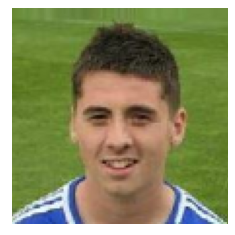

-----------------------
-----------------------
True Attributes among [wearing Eyeglasses, wearing_hat, mustache]:  
Predicted Attributes: 


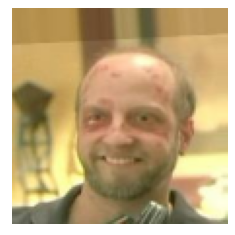

-----------------------
-----------------------
True Attributes among [wearing Eyeglasses, wearing_hat, mustache]:  Eyeglasses, Wearing_Hat
Predicted Attributes: Eyeglasses


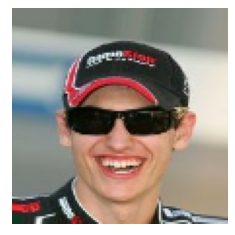

-----------------------
-----------------------
True Attributes among [wearing Eyeglasses, wearing_hat, mustache]:  
Predicted Attributes: 


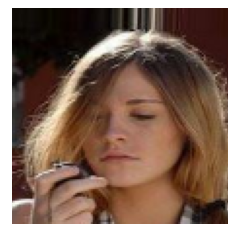

-----------------------
-----------------------
True Attributes among [wearing Eyeglasses, wearing_hat, mustache]:  
Predicted Attributes: 


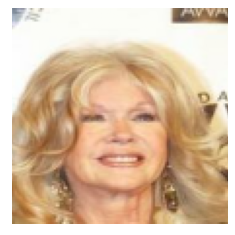

-----------------------


In [45]:
# Tuning Parameter
thershold = 0.4
#--------
batch = next(iter(test_ds))
test_images, test_labels = batch

# Predicting Labels
pred_labels = model.predict(test_images)

# Changing Predicted labels to One-Hot
pred_labels[pred_labels >= thershold] = 1
pred_labels[pred_labels < thershold] = 0

# Processing for plotting
test_images = test_images.numpy()[:5]
test_labels = test_labels.numpy()[:5]
pred_labels = pred_labels[:5]

# Finally Plotting
plot_images(test_images, test_labels, pred_labels)

# Model 3

## Model Architecture

In this approach we have used CNN to build & train a model to identify the different features. We have built the different layers from scratch and tried to fit in the data.

The class below maps the dataset into the format required for transforming and training the model.

In [16]:
class MultiClassCelebA(Dataset):
    
    def __init__(self, dataframe, folder_dir, transform = None):
        
        self.dataframe = dataframe
        self.folder_dir = folder_dir
        self.transform = transform
        self.file_names = dataframe.image_id
        self.labels = []
        for row in dataframe.iterrows():
            self.lbels.append([[row[1]["Eyeglasses"], row[1]["Mustache"], row[1]["Wearing_Hat"]]])
        
        
    def __len__(self):
        return len(self.dataframe)
    
    
    def __getitem__(self, index):
        
        image = Image.open(os.path.join(self.folder_dir, self.file_names[index]))
        label = self.labels[index][0]
        sample = {'image': image, 'label': np.array(label, dtype=np.float32)}
        if self.transform:
            image = self.transform(sample['image'])
            sample = {'image': image, 'label': np.array(label, dtype=np.float32)}
        
        return sample

In [17]:
tfms = transforms.Compose([transforms.Resize((256, 256)),
                           transforms.ToTensor()])

In [147]:
train_dl = MultiClassCelebA(train_split, celeba.images_folder, transform = tfms)

## Model Building

In [20]:
class MultiClassifier(nn.Module):
    def __init__(self):
        super(MultiClassifier, self).__init__()
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3), # 3, 256, 256
            nn.MaxPool2d(2), # op: 16, 127, 127
            nn.ReLU(), # op: 64, 127, 127
        )
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3), # 64, 127, 127   
            nn.MaxPool2d(2), #op: 128, 63, 63
            nn.ReLU() # op: 128, 63, 63
        )
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(128, 256, 3), # 128, 63, 63
            nn.MaxPool2d(2), #op: 256, 30, 30
            nn.ReLU() #op: 256, 30, 30
        )
        self.ConvLayer4 = nn.Sequential(
            nn.Conv2d(256, 512, 3), # 256, 30, 30
            nn.MaxPool2d(2), #op: 512, 14, 14
            nn.ReLU(), #op: 512, 14, 14
            nn.Dropout(0.2)
        )
        self.Linear1 = nn.Linear(512 * 14 * 14, 1024)
        self.Linear2 = nn.Linear(1024, 256)
        self.Linear3 = nn.Linear(256, 3)
        
        
    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = self.ConvLayer4(x)
        x = x.view(x.size(0), -1)
        x = self.Linear1(x)
        x = self.Linear2(x)
        x = self.Linear3(x)
        return F.sigmoid(x)

In [21]:
(train_dl[1029]['label'].astype(float))

array([0., 0., 1.])

In [22]:
valid_dl = MultiClassCelebA(valid_split, celeba.images_folder, transform = tfms)

In [23]:
valid_dl[1]['label']

array([0., 1., 0.], dtype=float32)

In [24]:
def check_cuda():
    _cuda = False
    if torch.cuda.is_available():
        _cuda = True
    return _cuda

In [25]:
is_cuda = check_cuda()

In [26]:
model = MultiClassifier()
if is_cuda:
    model.cuda()

In [27]:
train_dataloader = torch.utils.data.DataLoader(train_dl, shuffle = True, batch_size = 64, num_workers = 3)
valid_dataloader = torch.utils.data.DataLoader(valid_dl, shuffle = True, batch_size = 64, num_workers = 3)

In [28]:
def pred_acc(original, predicted):
    return torch.round(predicted).eq(original).sum().numpy()/len(original)

In [29]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

Here we will fit the trasformed data into the different layers for measuring the training and validation loss during each epoch of the training.

## Training

In [31]:
def fit_model(epochs, model, dataloader, phase = 'training', volatile = False):
    
    pprint("Epoch: {}".format(epochs))

    if phase == 'training':
        model.train()
        
    if phase == 'validataion':
        model.eval()
        volatile = True
        
    running_loss = []
    running_acc = []
    b = 0
    for i, data in enumerate(dataloader):
        

        inputs, target = data['image'].cuda(), data['label'].float().cuda()
        
        inputs, target = Variable(inputs), Variable(target)
        
        if phase == 'training':
            optimizer.zero_grad()
            
        ops = model(inputs)
        
        acc_ = []
        for i, d in enumerate(ops, 0):
           
            acc = pred_acc(torch.Tensor.cpu(target[i]), torch.Tensor.cpu(d))
            acc_.append(acc)

        loss = criterion(ops, target)
                
        running_loss.append(loss.item())
        running_acc.append(np.asarray(acc_).mean())
        b += 1
       
        if phase == 'training':
            
            loss.backward()
        
            optimizer.step()
            
    total_batch_loss = np.asarray(running_loss).mean()
    total_batch_acc = np.asarray(running_acc).mean()
    

    pprint("{} loss is {} ".format(phase,total_batch_loss))
    pprint("{} accuracy is {} ".format(phase, total_batch_acc))
    
    return total_batch_loss, total_batch_acc

In [33]:
trn_losses = []; trn_acc = []
val_losses = []; val_acc = []
for i in tqdm(range(1, 20)):
    trn_l, trn_a = fit_model(i, model, train_dataloader)
    val_l, val_a = fit_model(i, model, valid_dataloader, phase = 'validation')
    trn_losses.append(trn_l); trn_acc.append(trn_a)
    val_losses.append(val_l); val_acc.append(val_a)

  0%|          | 0/19 [00:00<?, ?it/s]

'Epoch: 1'


/home/rk/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/rk/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


'training loss is 0.201099319570938 '
'training accuracy is 0.946876182884929 '
'Epoch: 1'


  5%|▌         | 1/19 [07:17<2:11:18, 437.72s/it]

'validation loss is 0.18868977523789146 '
'validation accuracy is 0.9441008197372078 '
'Epoch: 2'
'training loss is 0.16290051155319474 '
'training accuracy is 0.9516120446802935 '
'Epoch: 2'


 11%|█         | 2/19 [14:39<2:04:36, 439.80s/it]

'validation loss is 0.15920910991464782 '
'validation accuracy is 0.9513963320233416 '
'Epoch: 3'
'training loss is 0.14010215013539828 '
'training accuracy is 0.9571211037590264 '
'Epoch: 3'


 16%|█▌        | 3/19 [22:00<1:57:25, 440.33s/it]

'validation loss is 0.1442040716241027 '
'validation accuracy is 0.9545280308443492 '
'Epoch: 4'
'training loss is 0.11333509132049321 '
'training accuracy is 0.9635835225949221 '
'Epoch: 4'


 21%|██        | 4/19 [29:23<1:50:11, 440.76s/it]

'validation loss is 0.10860203437722764 '
'validation accuracy is 0.9622316750029772 '
'Epoch: 5'
'training loss is 0.09363091019064235 '
'training accuracy is 0.9683751164686698 '
'Epoch: 5'


 26%|██▋       | 5/19 [36:45<1:42:55, 441.10s/it]

'validation loss is 0.0926794559661886 '
'validation accuracy is 0.9669165078797984 '
'Epoch: 6'
'training loss is 0.08139039457917693 '
'training accuracy is 0.972021586740042 '
'Epoch: 6'


 32%|███▏      | 6/19 [44:11<1:35:43, 441.84s/it]

'validation loss is 0.08375715357745575 '
'validation accuracy is 0.9694409709816999 '
'Epoch: 7'
'training loss is 0.07300410361677911 '
'training accuracy is 0.974531577568134 '
'Epoch: 7'


 37%|███▋      | 7/19 [51:36<1:28:27, 442.30s/it]

'validation loss is 0.07572910148901955 '
'validation accuracy is 0.9723884522250009 '
'Epoch: 8'
'training loss is 0.06816770315592019 '
'training accuracy is 0.9757711044869555 '
'Epoch: 8'


 42%|████▏     | 8/19 [58:58<1:21:05, 442.35s/it]

'validation loss is 0.07228659579105125 '
'validation accuracy is 0.9737282164265015 '
'Epoch: 9'
'training loss is 0.06590953007697 '
'training accuracy is 0.976412819560913 '
'Epoch: 9'


 47%|████▋     | 9/19 [1:06:21<1:13:44, 442.41s/it]

'validation loss is 0.07189769971624639 '
'validation accuracy is 0.9736779752689453 '
'Epoch: 10'
'training loss is 0.06364132106430835 '
'training accuracy is 0.9772553975949221 '
'Epoch: 10'


 53%|█████▎    | 10/19 [1:13:53<1:06:29, 443.32s/it]

'validation loss is 0.06981422097521005 '
'validation accuracy is 0.9745364167758326 '
'Epoch: 11'
'training loss is 0.06198466511966028 '
'training accuracy is 0.9776832834701841 '
'Epoch: 11'


 58%|█████▊    | 11/19 [1:21:16<59:06, 443.32s/it]  

'validation loss is 0.06833174232980446 '
'validation accuracy is 0.9744632259537137 '
'Epoch: 12'
'training loss is 0.0601229555989065 '
'training accuracy is 0.9781320973095737 '
'Epoch: 12'


 63%|██████▎   | 12/19 [1:28:39<51:43, 443.29s/it]

'validation loss is 0.06616815970162487 '
'validation accuracy is 0.9753985798499465 '
'Epoch: 13'
'training loss is 0.0585228937217503 '
'training accuracy is 0.9787171703936642 '
'Epoch: 13'


 68%|██████▊   | 13/19 [1:36:02<44:19, 443.27s/it]

'validation loss is 0.06505012421470459 '
'validation accuracy is 0.9755077458219207 '
'Epoch: 14'
'training loss is 0.057261206898999356 '
'training accuracy is 0.9790681687485442 '
'Epoch: 14'


 74%|███████▎  | 14/19 [1:43:25<36:56, 443.24s/it]

'validation loss is 0.06329112135808185 '
'validation accuracy is 0.9764517833750148 '
'Epoch: 15'
'training loss is 0.05578885775051408 '
'training accuracy is 0.9796006944444445 '
'Epoch: 15'


 79%|███████▉  | 15/19 [1:50:48<29:32, 443.23s/it]

'validation loss is 0.06203149494167022 '
'validation accuracy is 0.9766924447223214 '
'Epoch: 16'
'training loss is 0.05425613007029378 '
'training accuracy is 0.9800385893460285 '
'Epoch: 16'


 84%|████████▍ | 16/19 [1:58:11<22:09, 443.23s/it]

'validation loss is 0.060705798794889756 '
'validation accuracy is 0.9770732851018221 '
'Epoch: 17'
'training loss is 0.05287000168672815 '
'training accuracy is 0.9803611529670394 '
'Epoch: 17'


 89%|████████▉ | 17/19 [2:05:34<14:46, 443.23s/it]

'validation loss is 0.05972243163590933 '
'validation accuracy is 0.9777078123139216 '
'Epoch: 18'
'training loss is 0.05162077340804064 '
'training accuracy is 0.9807890388423014 '
'Epoch: 18'


 95%|█████████▍| 18/19 [2:12:57<07:23, 443.22s/it]

'validation loss is 0.05871705233847117 '
'validation accuracy is 0.9775422025723473 '
'Epoch: 19'
'training loss is 0.05086285170953305 '
'training accuracy is 0.9811382173742138 '
'Epoch: 19'


100%|██████████| 19/19 [2:20:20<00:00, 443.21s/it]

'validation loss is 0.05832370525747058 '
'validation accuracy is 0.9776699763804534 '


In [34]:
torch.save(model, "CNN_Model_3_")

## Testing the model 

In [50]:
def get_tensor(img):
    tfms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    
    return tfms(Image.open(img)).unsqueeze(0)

In [141]:
def predict(img, label_lst, model):
    tnsr = get_tensor(img)
    op = model(tnsr)
    op_b = torch.round(op)
    op_b_np = torch.Tensor.cpu(op_b).detach().numpy()
    preds = np.where(op_b_np == 1)[1]
    sigs_op = torch.Tensor.cpu(torch.round((op)*100)).detach().numpy()[0]
    o_p = np.argsort(torch.Tensor.cpu(op).detach().numpy())[0][::-1]
    label = []
    for i in preds:
        label.append(label_lst[i])
    arg_s = {}
    for i in o_p:
        arg_s[label_lst[int(i)]] = sigs_op[int(i)]
    return label, list(arg_s.items())[:10], op_b_np

Getting the confusion matrix to see how the model performs on the test data 

In [143]:
from sklearn.metrics import confusion_matrix
labels = ["Eyeglasses", "Mustache", "Wearing_Hat"]
y_test = []
predicted = []
for row in test_set.iterrows():
    pred_labels, top_attributes, final_pred = (predict("celeba-dataset/img_align_celeba/img_align_celeba/" + row[1]["image_id"], labels, model))
    y_test.append(np.array([row[1]["Eyeglasses"], row[1]["Mustache"], row[1]["Wearing_Hat"]]))
    predicted.append(np.array(final_pred[0], dtype=np.int))
    
print(confusion_matrix(np.array(y_test).argmax(axis=1), np.array(predicted).argmax(axis=1)))    

/home/rk/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[[18547    85    80]
 [  387   180    67]
 [  151    10   455]]


#### Testing the model on Random Sample Set

-----------------------
True Attributes among [wearing Eyeglasses, wearing_hat, mustache]:  Wearing_Hat ,
Predicted Attributes: 


/home/rk/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


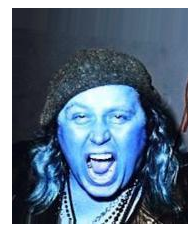

-----------------------
-----------------------
True Attributes among [wearing Eyeglasses, wearing_hat, mustache]:  
Predicted Attributes: 


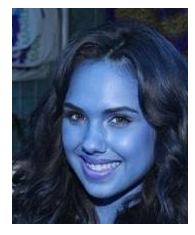

-----------------------
-----------------------
True Attributes among [wearing Eyeglasses, wearing_hat, mustache]:  
Predicted Attributes: 


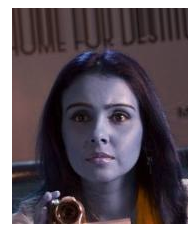

-----------------------
-----------------------
True Attributes among [wearing Eyeglasses, wearing_hat, mustache]:  Eyeglasses ,
Predicted Attributes: Eyeglasses ,


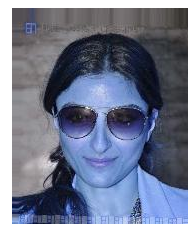

-----------------------
-----------------------
True Attributes among [wearing Eyeglasses, wearing_hat, mustache]:  
Predicted Attributes: 


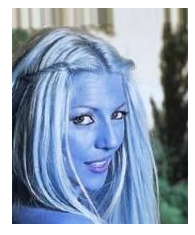

-----------------------


In [119]:
def get_label_string(labels_list, type=None):
    label_map = {0: "Eyeglasses", 1: "Mustache", 2: "Wearing_Hat"}
    true_label = ""
    if type == "pred":
        for index, prediction in enumerate(labels_list):
            if prediction[1] > 40:
                true_label += label_map[index] + ", "
    else:
        for index, value in enumerate(labels_list):
            if value == 1:
                true_label += label_map[index] + ", "
    return true_label

def plot_images(images, labels_list, pred_labels=[]):
    _ = plt.figure(figsize=(4, 4))
    print('-----------------------')
    print('True Attributes among [wearing Eyeglasses, wearing_hat, mustache]: ', get_label_string(labels_list))
    print('Predicted Attributes:', get_label_string(pred_labels, "pred"))
    img = cv2.imread(images)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    print('-----------------------')
        
model_path = "CNN_Model_3_"
model = torch.load(model_path, map_location=torch.device('cpu'))
model = model.eval()


random_sample = test_set.sample(n=5)
labels = ["Eyeglasses", "Mustache", "Wearing_Hat"]
for row in random_sample.iterrows():
    pred_labels, top_attributes, final_pred = (predict("celeba-dataset/img_align_celeba/img_align_celeba/" + row[1]["image_id"], labels, model))
    plot_images("celeba-dataset/img_align_celeba/img_align_celeba/" + row[1]["image_id"], [row[1]["Eyeglasses"], row[1]["Mustache"], row[1]["Wearing_Hat"]], top_attributes)


In [120]:
model.eval()

MultiClassifier(
  (ConvLayer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (ConvLayer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
  )
  (ConvLayer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (Linear1): Linear(in_features=100352, out_features=1024, bias=True)
  (Linear2): Linear(in_features=1024, out_features=256, bias=True)
  (Linear3): Linear(in_features=256, ou